In [1]:
import numpy as np
import os

import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd

Using TensorFlow backend.


In [2]:
## carregando as imagens

input_images = '../data/raw/full_numpy_bitmap_airplane.npy'
data = np.load(input_images)
data[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  59,  92, 101,
        36,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 174, 255,
       255, 255, 245,  53,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       131, 255,  89,  30, 216, 228,  25,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   7, 214, 216,   8,  38, 239, 199,   7,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  64, 254, 148,   1,  73, 252, 15

In [19]:
data.shape

(151623, 784)

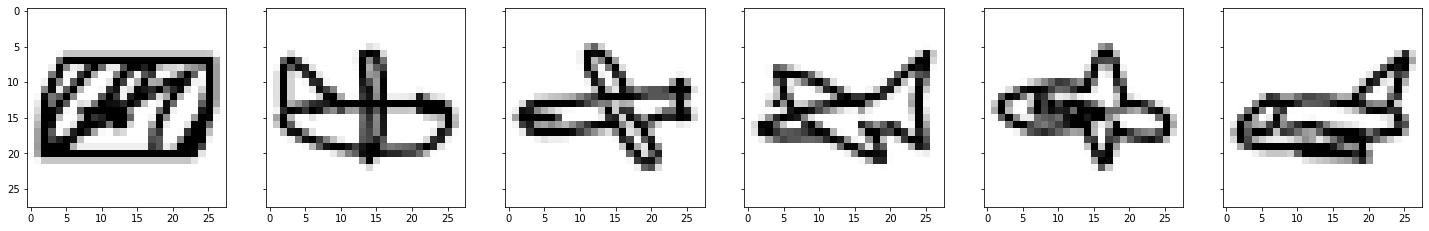

In [20]:
## verificando os dados

f, ax = plt.subplots(1,6,sharey=True,figsize=(25,8))

for i in range(6):
    ax[i].imshow(data[np.random.randint(0,data.shape[0])].reshape(28,28),cmap='Greys')

In [21]:
## verificando o shape

data.shape

(151623, 784)

In [22]:
## normalizando as imagens

data = data/255

## transformando os vetores de 784 para 28x28x1

data = np.reshape(data,(data.shape[0],28,28,1))

img_w, img_h = data.shape[1:3]

data.shape

(151623, 28, 28, 1)

## discriminator

In [23]:
## construindo o descriminador

def build_discriminator(depth=64, p=0.4) -> keras.models.Model:
    
    ## inputs
    image = Input(shape=(img_w,img_h,1))
    
    ## conv block 1
    conv1 = Conv2D(depth * 1, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1) 
    
    ## conv block 2
    conv2 = Conv2D(depth * 2, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    ## conv block 3
    conv3 = Conv2D(depth * 4, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3) 
    
    ## conv block 4
    conv4 = Conv2D(depth * 8, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu')(conv3)
    conv4 = Dropout(p)(conv4)
    
    ## flatten block
    flatten_block = Flatten()(conv4)
    
    ## output
    prediction = Dense(1,activation='sigmoid')(flatten_block)
    
    ## model
    model = Model(image,prediction,name='Discriminador')
    
    return model

In [24]:
## instanciando o discriminador

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminador"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)       

In [25]:
## compilando o discriminador

discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0),
                     metrics=['accuracy'])

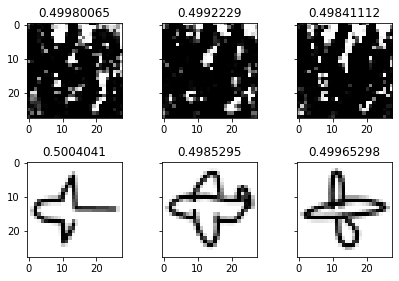

In [59]:
f, ax = plt.subplots(2,3,sharey=True)

for i in range(6):
    
    if i < 3 :
        np.random.seed(i*42)
        random_noise = [[np.random.randint(0,255,32)]]
        
        generated = generator.predict(random_noise)
        generated = generated.reshape(28,28)

        ax[0,i].set_title(discriminator.predict(generated.reshape(1,28,28,1))[0][0])
        ax[0,i].imshow(generated,cmap='Greys')
        
    else:
        ax[1,i-3].set_title(discriminator.predict([[data[i]]])[0][0])
        ax[1,i-3].imshow(data[i].reshape(28,28),cmap='Greys')

plt.tight_layout()

Aqui temos o modelo `discriminator` que gera uma predição sobre uma imagem de input, ou seja, ele recebe uma imagem e diz se ela é real ou falsa. Como ele ainda não foi treinado, o `discriminator` não sabe diferenciar as imagens gerando um output sempre próximo a 0.5 (devido também a ativação da última camada).

## generator

In [27]:
## determinando o tamanho do noise_vector para o gerador

z_dimensions = 32

In [28]:
## criando o gerador

def build_generator(latent_dim=z_dimensions,
                   depth=64,p=0.4) -> keras.models.Model:
    
    ## inputs
    noise_vector = Input((latent_dim,))
    
    ## dense layer
    dense1 = Dense((7*7*depth))(noise_vector)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    ## deconv1
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2),
                            kernel_size=(5,5),
                            padding='same',
                            activation=None)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    ## deconv2
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4),
                            kernel_size=(5,5),
                            padding='same',
                            activation=None)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    ## deconv3
    conv3 = Conv2DTranspose(int(depth/8),
                            kernel_size=(5,5),
                            padding='same',
                            activation=None)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    ## output
    image = Conv2D(1,kernel_size=(5,5),
                   padding='same',
                  activation='sigmoid')(conv3)
    
    model = Model(noise_vector,image,name='Gerador')
    
    return model

In [29]:
## instanciando o gerador

generator = build_generator()
generator.summary()

Model: "Gerador"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)        5123

[246   0  52  63  21  54  67 252  92  97 160 254 119 210 109  99 165 215
  45 220 183  73 162  29 245  77 115 142 100 200  79 190]
 


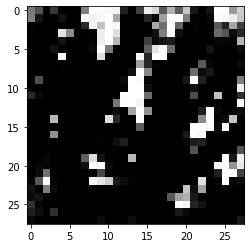

In [40]:
random_noise = [[np.random.randint(0,255,32)]]

generated = generator.predict(random_noise)
generated = generated.reshape(28,28)

print(random_noise[0][0])
print(' ')

plt.imshow(generated,cmap='Greys');

Acima temos o `generator` criando imagens a partir de um input noise_vector. Ou seja, o modelo acima está preparado para receber um vetor de 32 dimensões que vai ser transformado em fotos de avião!

## Adversarial

In [14]:
z_vector = Input(shape = (z_dimensions,),name='VetorDeEntrada')
image = generator(z_vector)

discriminator.trainable = False
pred = discriminator(image)

adversarial_model = Model(z_vector, pred)
adversarial_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VetorDeEntrada (InputLayer)  (None, 32)                0         
_________________________________________________________________
Gerador (Model)              (None, 28, 28, 1)         183713    
_________________________________________________________________
Discriminador (Model)        (None, 1)                 4311553   
Total params: 4,495,266
Trainable params: 177,329
Non-trainable params: 4,317,937
_________________________________________________________________


In [15]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=RMSprop(lr=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

In [16]:
adversarial_model.predict(random_noise)

array([[0.49782932]], dtype=float32)

O modelo `adversarial_model` recebe um vetor de valores com dimensão igual a 32. Esses valores são passados para o modelo `generator` , o output dessa camada ( que é uma imagem 28,28,1 ) é então enviado para o `discriminator` que entrega uma predição. 

## Training

In [17]:
def train(epochs= 2000, batch=128, z_dim = z_dimensions):
    
    ## metricas de avaliacao
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    ## gerando a gif
    noise_gif = np.random.uniform(-1,1,size=[4,32])
    
    ## training
    for i in range(epochs):
        
        ## amostragem de imagens REAIS
        """ aqui eu estou fazendo uma amostragem de 128 imagens reais """
        
        real_images = data[np.random.choice(data.shape[0],batch,replace=False)]
        real_images = real_images.reshape(batch,28,28,1)
        
        
        ## gerando as imagens FAKE
        """ aqui vou utilizando um vetor para gerar mais 128 imagens FAKE """
        
        vetores_de_entrada = np.random.uniform(-1, 1, size=[batch,z_dim])
        fake_images = generator.predict(vetores_de_entrada)
        
        
        ## juntando as duas listas de images
        """ agora é hora de juntar as duas listas formando o X que será enviado para os modelos """

        x = np.concatenate((real_images,fake_images))
        
        
        ## gerando os Y
        """ agora vou gerar o Y, sei que as 128 primeiras imagens são reais (1) e que as 128 finais 
        são falsas (0) """

        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        
        ##########################################################################
        ##=== treinando o discriminador ===##
        """ aqui o trabalho é treinar somente o discriminador, entrando com os dados gerados acima
        para que ele atualize seus pesos e fique melhor em diferenciar uma imagem real de uma imagem fake """
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]

        
        """ o método train_on_batch faz com que o modelo treine somente naquele batch e retorna dois valores, o
        primeiro representa a loss e o segundo valor a métrics escolhida na no momento da compilação do modelo"""
        
        ###########################################################################
        ##=== treinando o gerador ===##
        """ aqui o trabalho é treinar somente o gerador. Neste caso passo o vetor de entrada 
        de 32 valores (ou dimensões) para a rede que então passa isso para um gerador e a saída do gerador
        entra no discriminador. O discriminador já foi treinado na etapa acima. Como passo somente Y 
        com valor 1 quando as imagens geradas forem de fato de um avião ele vai retonar um erro baixo e, 
        como travamos o treinamento dele na rede adversarial, somente a rede geradora irá 
        sofrer alterações no backpropagation"""
        
        noise = np.random.uniform(-1, 1, size=[batch,z_dim])
        y = np.ones([batch,1])
        
        a_metrics.append(adversarial_model.train_on_batch(noise,y))
        
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        
        ###########################################################################

        if (i+1)%100 == 0:
            
            print('Epoch #',i)
            log_mesg = "%d: [D loss: %f, acc: %f]" %(i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" %(log_mesg, running_a_loss/i, running_a_acc/i)
            
            noise = np.random.uniform(-1,1,size=[16,z_dim])
            generated_images = generator.predict(noise)
            
            plt.figure(figsize=(5,5))
            
            for k in range(generated_images.shape[0]):
                plt.subplot(4,4,k+1)
                plt.imshow(generated_images[k,:,:,0],cmap='Greys')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
            
        ### gerando o gif ###
        
        generated_gif = generator.predict(noise_gif)
        
        f = plt.figure(figsize=(5,5))
        my_suptitle = f.suptitle(f'Epoch #{i}',y=1.05)

        for k in range(4):
            plt.subplot(2,2,k+1)
            plt.imshow(generated_gif[k,:,:,0],cmap='Greys')

        f.tight_layout()
        f.savefig(f'../images/images_epoch{i}.png', bbox_extra_artists=(my_suptitle,), bbox_inches="tight")
        plt.close()
        
                
    return a_metrics, d_metrics

/home/nasserboan/miniconda3/envs/deep/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/nasserboan/miniconda3/envs/deep/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch # 99


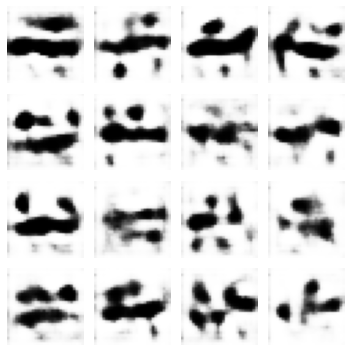

Epoch # 199


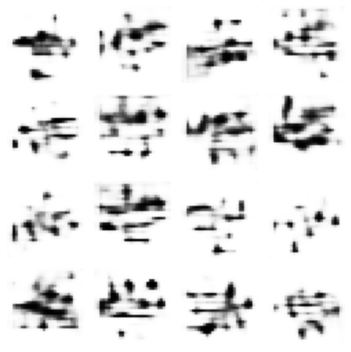

Epoch # 299


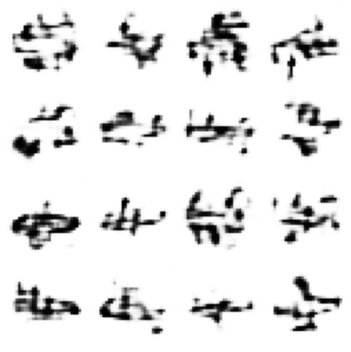

Epoch # 399


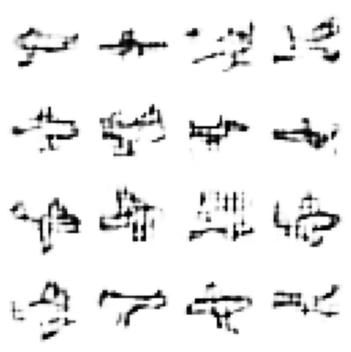

Epoch # 499


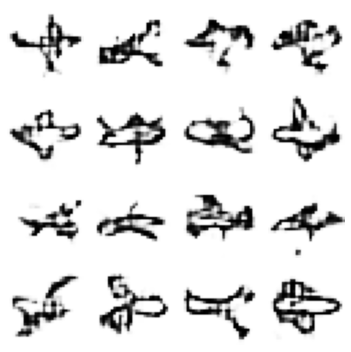

Epoch # 599


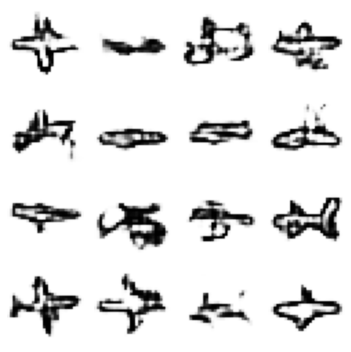

Epoch # 699


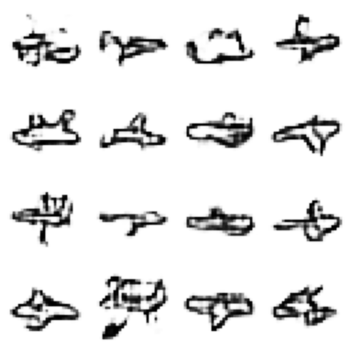

Epoch # 799


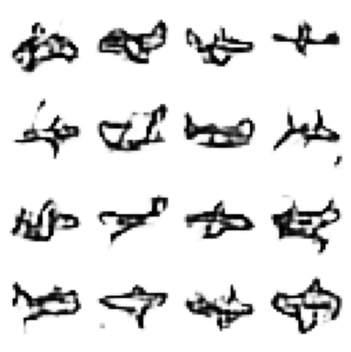

Epoch # 899


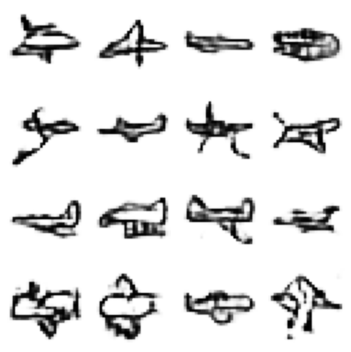

Epoch # 999


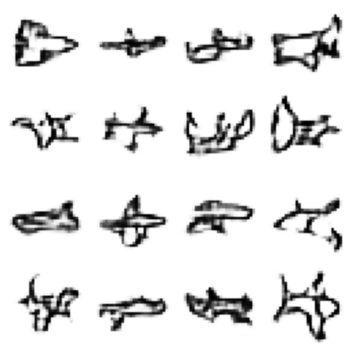

Epoch # 1099


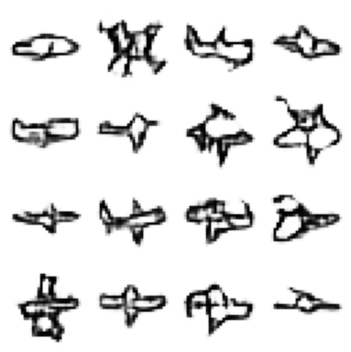

Epoch # 1199


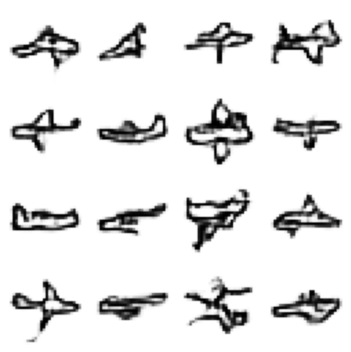

Epoch # 1299


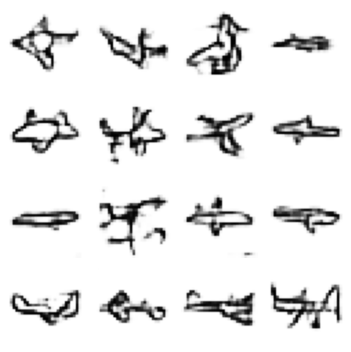

Epoch # 1399


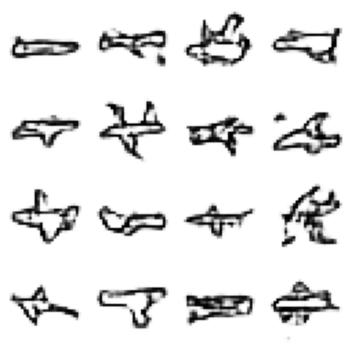

Epoch # 1499


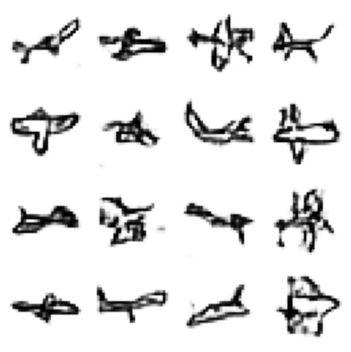

Epoch # 1599


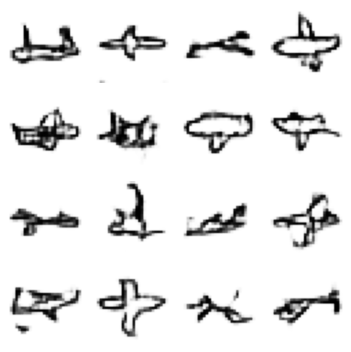

Epoch # 1699


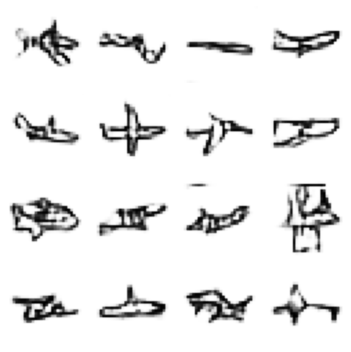

Epoch # 1799


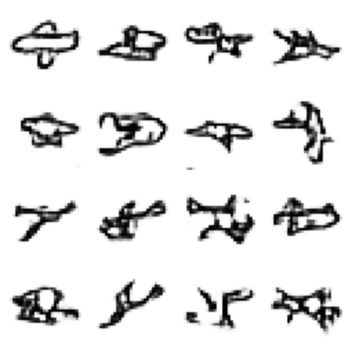

Epoch # 1899


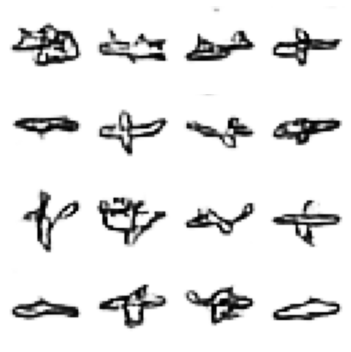

Epoch # 1999


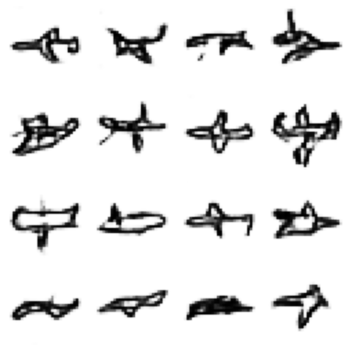

In [18]:
a_metrics_complete, d_metrics_complete = train()

In [59]:
## gerando o gŕafico de loss

for i in range(2000):
    plt.plot(np.array(a_metrics_complete)[:i,0],alpha=0.5)
    plt.scatter(i,np.array(a_metrics_complete)[i,0],c='red',s=100)
    plt.axis([-100,2100,-1,15])
    plt.xlabel('Epochs')
    plt.ylabel('Generator Loss')
    plt.savefig(f'../images2/image{i}.png')
    plt.close()